In [52]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.13.0
1 Physical GPUs, 1 Logical GPUs


In [53]:
! pip install opendatasets --upgrade --quiet

In [54]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/alessiocorrado99/animals10'
od.download(dataset_url)

Skipping, found downloaded files in "./animals10" (use force=True to force download)


In [55]:
data_dir = './animals10/raw-img'
os.listdir(data_dir)

['cavallo',
 'farfalla',
 'mucca',
 'scoiattolo',
 'gallina',
 'pecora',
 'cane',
 'gatto',
 'elefante',
 'ragno']

In [56]:
total_img = 0

for x in os.listdir(data_dir):
    total_img += len(os.listdir(os.path.join(data_dir, x)))
    files = os.listdir(os.path.join(data_dir, x))
    print(f'{x} has {len(files)} images')
    
print(f'Total images: {total_img}')

cavallo has 2623 images
farfalla has 2112 images
mucca has 1866 images
scoiattolo has 1862 images
gallina has 3098 images
pecora has 1820 images
cane has 4863 images
gatto has 1668 images
elefante has 1446 images
ragno has 4821 images
Total images: 26179


In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [58]:
animals = list(train_generator.class_indices.keys())
print(animals)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [59]:
for x, y in train_generator:
    print(x.shape, y.shape)
    break

(32, 224, 224, 3) (32, 10)


In [64]:
tf.random.set_seed(42)

resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in resnet.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    resnet,
    tf.keras.layers.Conv2D(64, (2,2), activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()
model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_62 (Conv2D)          (None, 6, 6, 64)          524352    
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 3, 3, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 2, 2, 64)          16448     
                                                                 
 batch_normalization_16 (Ba  (None, 2, 2, 64)          256       
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1  (None, 64)              

In [65]:
tf.random.set_seed(42)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print(f'\nReached 95% accuracy so cancelling training!')
            self.model.stop_training = True
            
callback = ([
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
655/655 [==============================] - 68s 96ms/step - loss: 0.2387 - accuracy: 0.9302 - val_loss: 0.1373 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 2/50
655/655 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9644
Reached 95% accuracy so cancelling training!
655/655 [==============================] - 64s 97ms/step - loss: 0.1181 - accuracy: 0.9644 - val_loss: 0.1334 - val_accuracy: 0.9614 - lr: 0.0010


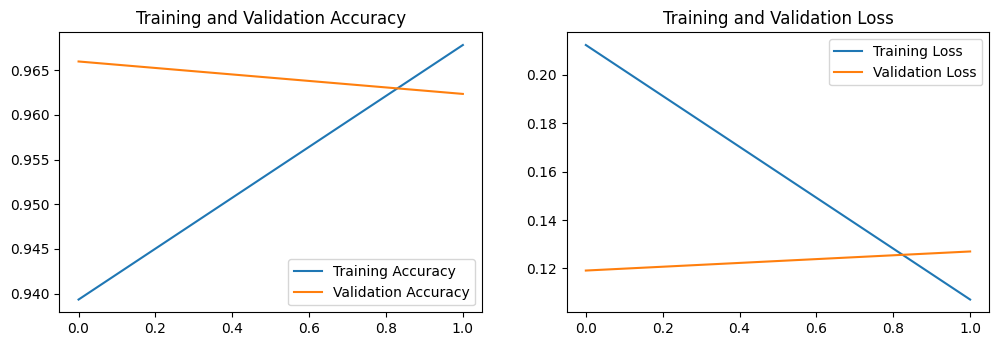

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)